# Use Case:

In Software Testing Life Cycle(STLC), once a defect is identified and logged into the defect management tools, Scrum Master / Defect Manager / BA will look at the defects and validate them to see if they are valid / invalid defects . Whenever the defect manager qualify a defect as invalid, he will write comments explaining why the particular defect is marked as invalid. These reasons vary from defect to defect and they can be Duplicates, As per design, Test Data issue, Test Environment issue etc.


Requirement:

Given the list of defects with some relevant data along with their comments, Build a model which will automate defect manager’s job of validating the defects. A model should take the new defects as an input and should classify each defect either Accept / Reject (Valid / In-Valid) along with the confidence score for each. Also, for an invalid defect, Model should let the user know what could be the possible reason to reject that particular defect.  


Data consists of two files in json format:

Valid defects
Invalid / Cancelled defects
along with their comments and other relevant data.
Data is attached in the doc. The data dictionary is given below.



1.      Status: The status of the defect

2.      Description: The user description related to the defect.

3.      Summary: Summary related to the defect

4.      Comments: The comments related to the defect.

5.      Root cause: What is the root cause of the defect

6.      Priority: The priority of the defect(High, Medium, Low )

7.      Assignee: The developer assigned to the defect.

8.      Application: The application name in which the defect was raised.

 **bold text**

In [1]:
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm


Reading the data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df=pd.read_json('/content/drive/MyDrive/Data/cancelled.json')
dfv0=pd.read_json('/content/drive/MyDrive/Data/sailorapp.json')
dfv1=pd.read_json('/content/drive/MyDrive/Data/noncancelled.json')

combining the three datasets which we have

In [5]:
df['type']='invalid'
dfv1['type']='valid'
dfv0['type']='valid'
dfv0['Component']=' '
df_combined=pd.concat([df,dfv0,dfv1])

In [6]:
df['Status'].value_counts()

Canceled    2411
Name: Status, dtype: int64

In [7]:
dfv0['Status'].value_counts()

Done                 3884
Triage                836
Backlog               191
CERT Drop Pending     125
CERT Test              98
Committed              93
Reopened               64
Blocked                37
PO Review              37
In Progress            31
Prod Drop              18
Prod Test               8
STAGE Test              5
Name: Status, dtype: int64

In [8]:
dfv1['Status'].value_counts()

Done                 2589
Triage                285
Backlog               151
CERT Test             116
Committed              43
Blocked                28
In Progress            20
PO Review              18
Reopened               17
Prod Test               4
STAGE Test              4
Prod Drop               2
CERT Drop Pending       1
Name: Status, dtype: int64

In [9]:
df_combined['type'].value_counts()

valid      8705
invalid    2411
Name: type, dtype: int64

**Remove duplicate columns in Issuekey column**
The dataset provided includes an 'IssueKey' column, which serves as a unique identifier for each defect. During exploratory data analysis, we discovered that some 'IssueKey' entries were duplicated This duplication can introduce bias into our model, as it would overemphasize the repeated information.

**Feature engineering:**
The 'Description' and 'Summary' columns contain textual information about each defect. By combining these two columns into a single text feature, we can provide our model with a more comprehensive view of the defect's context. This concatenation of text fields is a common practice in natural language processing, allowing the model to draw connections between related pieces of information across different text fields.

**Drop duplicates:** dropping duplicates in text column

**Label Encoder:** Converting our target variable into numerical where Valid:1 and Invalid:0

In [10]:
# Assuming df is your DataFrame
# Group by 'issuekey' and count occurrences
issuekey_counts = df_combined.groupby('IssueKey').size()

# Filter the DataFrame where count values are greater than 1
filtered_df = df_combined[df_combined['IssueKey'].isin(issuekey_counts[issuekey_counts > 1].index)]
canceled=filtered_df[filtered_df['Status']=='Canceled']
canceled_list=canceled['IssueKey'].to_list()
df_total=df_combined[~df_combined['IssueKey'].isin(canceled_list)]
df_total['text'] = df_total['Description'] + ' ' + df_total['Summary']

In [11]:
df_total['type']=df_total['type'].apply(lambda x: 1 if x=='valid' else 0)
df_total_new=df_total.drop_duplicates(subset='text')

***Data Cleaning : ***
Our preprocessing includes stripping HTML tags and extraneous text from the 'text' column, employing stopword removal to focus on meaningful words, and applying lemmatization to consolidate word variants. These steps refine the input, significantly improving the model's learning efficiency and accuracy.

In [12]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Ensure that the necessary NLTK data is downloaded
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

def clean_text(text):
    """Clean raw text string, remove stopwords, and apply lemmatization."""
    # Initialize WordNet Lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Define English stopwords
    stop_words = set(stopwords.words('english'))

    # Remove patterns like [~accountid:...] and numbers
    text = re.sub(r'\[~accountid:\w+\]|\d+', '', text)

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove unnecessary characters
    text = re.sub(r"[\r\n]+", " ", text)  # Replace newlines with spaces
    text = re.sub(r"[^\w\s]+", " ", text)  # Remove non-alphanumeric characters except spaces
    text = re.sub(r"\s+", " ", text)  # Remove multiple spaces

    # Strip leading and trailing whitespace
    text = text.strip()

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords and lemmatize the words
    filtered_tokens = [lemmatizer.lemmatize(word.lower()) for word in tokens if word.lower() not in stop_words]

    # Join the cleaned tokens back into a string
    clean_text = ' '.join(filtered_tokens)

    return clean_text


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [13]:
df_total_new['text'] = df_total_new['text'].apply(lambda x: clean_text(x))

In [14]:
df=df_total_new.reset_index()

In [15]:
df.shape

(8059, 15)

In [16]:
df.head()

,index,Status,Description,Comments,Priority,RootCause,Reporter,IssueKey,Summary,Sprint,Component,Application,Assigne,type,text
0,0,Canceled,"Build: PI7.6 FE + 8.2 BE Hotfix , App Version:...",[],P3 - Medium,NA,Anusha Boosa,MSH-45790,CERT|SailorAPP| On-board | Cabin Services | I...,,NA,Sailor App,Anusha Boosa,0,build pi fe hotfix app version device android ...
1,1,Canceled,Ship parse count for housekeeping requests:\r\...,[{'author': {'accountId': '5e8b26768764110b816...,P3 - Medium,Code,Shanthi K,MSH-45793,Counts in the parse tables are not matching be...,PI8.4,NA,Crew VXP,Anagha Sebastian,0,ship parse count housekeeping request image pn...
2,2,Canceled,Hi [~accountid:5ade5093027e7a2ebfcbd97e] / [~a...,[{'author': {'accountId': '5ade5093027e7a2ebfc...,P2 - High,NA,Kapil Soni,MSH-45795,Magnolia | KAFKA | Ship Side Events are not co...,,NA,Sailor App,Kapil Soni,0,hi accountid ffc e f b fccefde getting event l...
3,3,Canceled,Ship side team has successfully uploaded the s...,[{'author': {'accountId': '5caee6ee6c3b6b270f4...,P2 - High,NA,Exalate,MSH-45830,VV-Prod-Ship | VM - Bulk uploaded successfully...,,"""Crew VXP""",Crew VXP,Himanshu Kumawat,0,ship side team successfully uploaded sheet vis...
4,4,Canceled,Hit the application url and do the booking flo...,[{'author': {'accountId': '5dcdc9960e14000dd49...,P4 - Low,NA,Punithavalli,MSH-45840,DWP-QA-Spinner getting displayed in the top le...,,NA,eCommerce,Punithavalli,0,hit application url booking flow actual result...


**EDA**

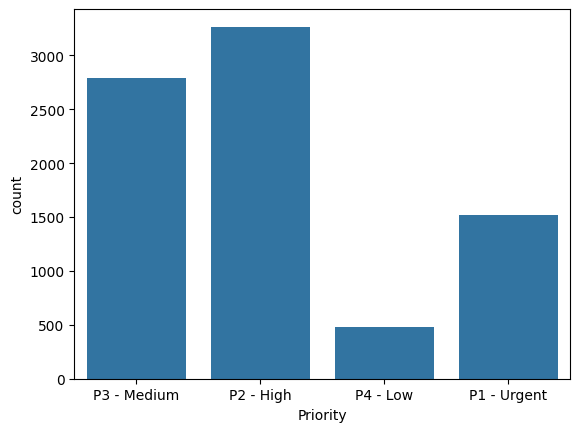

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example for visualizing the distribution of Priority
sns.countplot(x='Priority', data=df)
plt.show()


IN The bar chart visualizes the distribution of defect priorities, indicating a higher prevalence of 'High' and 'Medium' priority defects, with 'Urgent' and 'Low' defects being the least common.

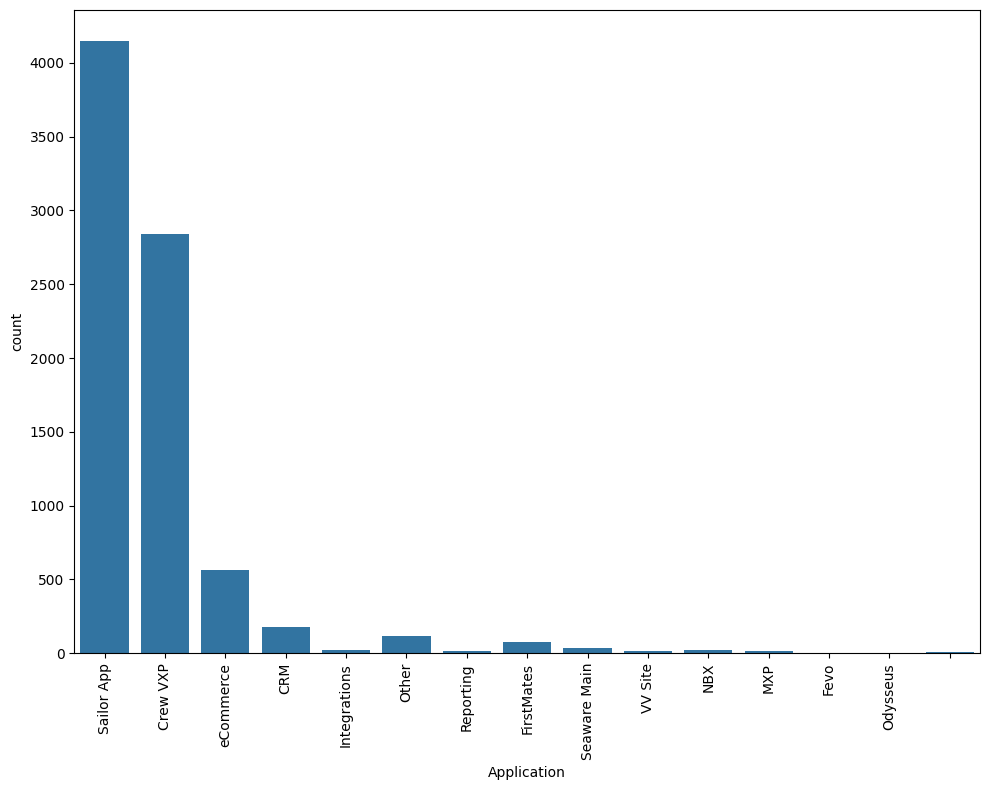

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example for visualizing the distribution of Priority
plt.figure(figsize=(10,8))  # Increase figure size
sns.countplot(x='Application',data=df)
plt.xticks(rotation=90)  # Rotate labels to be vertical
plt.tight_layout()  # Adjust layout to fit the plot and labels
plt.show()


Applications are more we have observed in 'Sailor App' and 'crew vxp'

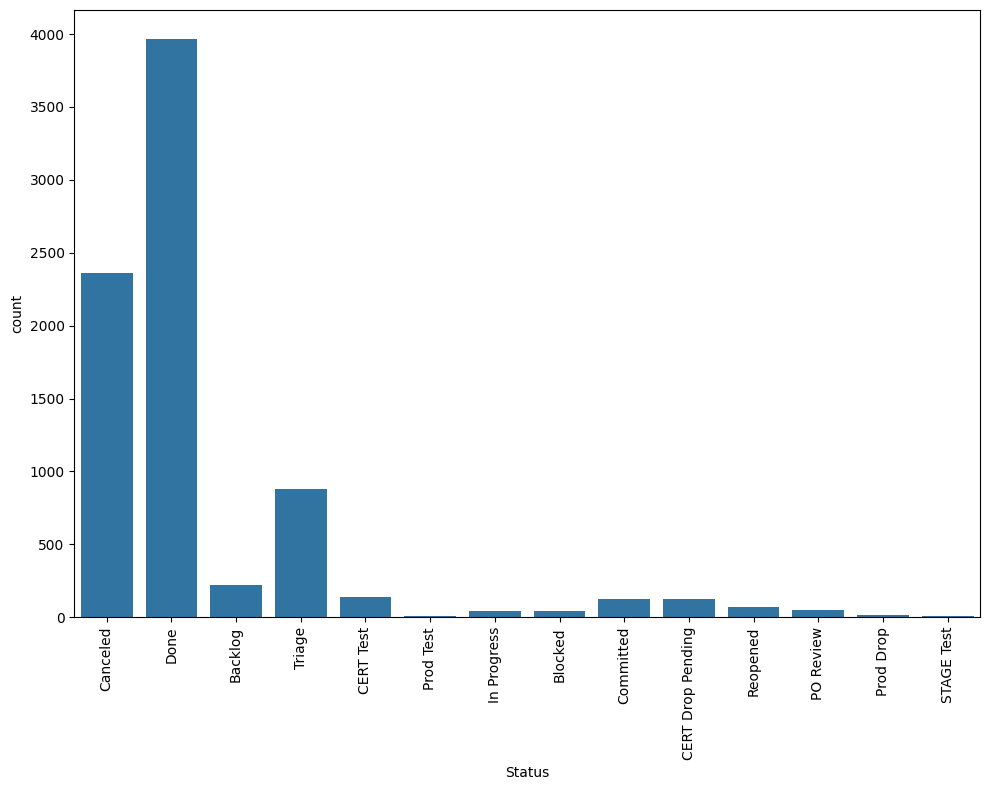

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example for visualizing the distribution of Priority
plt.figure(figsize=(10,8))  # Increase figure size
sns.countplot(x='Status',data=df)
plt.xticks(rotation=90)  # Rotate labels to be vertical
plt.tight_layout()  # Adjust layout to fit the plot and labels
plt.show()


The bar chart indicates a significant number of defects are categorized as 'Cancelled', suggesting a high volume of invalid defects. 'Done' signifies validated defects, other classes which are fewer in comparison. This disparity underlines the importance of an automated binary classification model to efficiently distinguish between valid and invalid defects in the STLC.

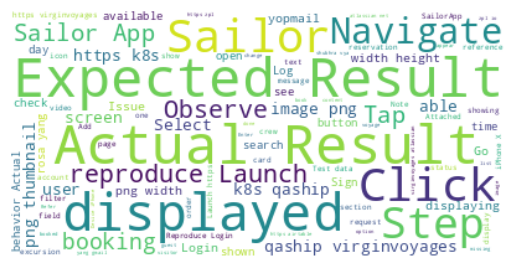

In [27]:
from wordcloud import WordCloud

# Example for creating a word cloud of the Description column
text = ' '.join(description for description in df['Description'])
wordcloud = WordCloud(background_color='white').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


most words used in 'Description' text column

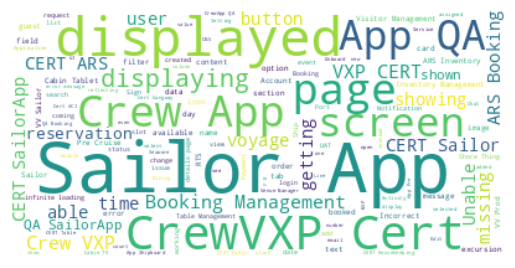

In [28]:
from wordcloud import WordCloud

# Example for creating a word cloud of the Description column
text = ' '.join(description for description in df['Summary'])
wordcloud = WordCloud(background_color='white').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


most words used in 'Summary' text column

**Data Split**

In our model construction, the pivotal 'text' column—encompassing rich defect descriptions—is the independent variable driving the analysis. The 'type' of the defect, serving as the target variable

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
# Split dataset
test_size = 0.2
train_df, val_df = train_test_split(df, stratify=df.type, test_size=test_size, random_state=1234)

**Logistic Regression with TFIDF**

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np


# Feature extraction without specifying max_features
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(train_df['text'])
X_val_tfidf = vectorizer.transform(val_df['text'])

# Calculate class weights for imbalance handling
class_weights = compute_class_weight('balanced',
                                    classes=np.unique(train_df['type']),
                                    y=train_df['type'])
class_weights_dict = dict(enumerate(class_weights))

# Model training with class weights
model = LogisticRegression(max_iter=1000, class_weight=class_weights_dict)
model.fit(X_train_tfidf, train_df['type'])

# Model validation
y_val_pred = model.predict(X_val_tfidf)

# Performance evaluation on the validation set
accuracy = accuracy_score(val_df['type'], y_val_pred)
report = classification_report(val_df['type'], y_val_pred)

print("Accuracy on validation set:", accuracy)
print("Classification Report on validation set:\n", report)


Accuracy on validation set: 0.738833746898263
Classification Report on validation set:
               precision    recall  f1-score   support

           0       0.55      0.58      0.57       472
           1       0.82      0.80      0.81      1140

    accuracy                           0.74      1612
   macro avg       0.69      0.69      0.69      1612
weighted avg       0.74      0.74      0.74      1612



**SMOTE**

In [30]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_df['text'])
y_train = train_df['type']
X_val = vectorizer.transform(val_df['text'])
y_val = val_df['type']

In [31]:
from imblearn.over_sampling import SMOTE

In [32]:
smote = SMOTE(random_state=1234)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [33]:
X_train_resampled.shape

(9116, 11679)

In [34]:
from collections import Counter

In [35]:
# Check the class distribution after SMOTE
print('Original dataset shape %s' % Counter(y_train))
print('Resampled dataset shape %s' % Counter(y_train_resampled))

Original dataset shape Counter({1: 4558, 0: 1889})
Resampled dataset shape Counter({1: 4558, 0: 4558})


In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Train a logistic regression model on the resampled training data
model = LogisticRegression(random_state=1234, max_iter=1000)

# Fit the model
model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
y_pred = model.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

# Print out the results
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)


Accuracy: 0.7450372208436724
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.56      0.56       472
           1       0.82      0.82      0.82      1140

    accuracy                           0.75      1612
   macro avg       0.69      0.69      0.69      1612
weighted avg       0.74      0.75      0.74      1612



#** LR with Random search optimisation**

In [37]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.linear_model import LogisticRegression

# Assuming X_train_resampled and y_train_resampled are your resampled training data
# Assuming X_val and y_val are your validation data

# Set up the parameter distribution for RandomizedSearchCV
param_distribution = {
    'C': uniform(loc=0, scale=4),  # Regularization strength (inverse)
    'penalty': ['l1', 'l2'],      # Type of regularization to use
    'solver': ['liblinear', 'saga']  # Solvers that support both l1 and l2 penalties
}

# Initialize the Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000)

# Initialize RandomizedSearchCV with the Logistic Regression model and parameter distribution
random_search = RandomizedSearchCV(
    estimator=logistic_model,
    param_distributions=param_distribution,
    n_iter=100,  # Number of parameter settings to try; increase or decrease based on computational budget
    cv=5,        # 5-fold cross-validation
    verbose=1,
    n_jobs=-1,   # Use all available cores
    random_state=42,
    scoring='f1_macro'  # Because we care about both classes equally
)

# Fit RandomizedSearchCV to the resampled training data
random_search.fit(X_train_resampled, y_train_resampled)

# Get the best hyperparameters and the corresponding best score
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Score on Training Data (F1 Macro):", best_score)

# Use the best estimator to make predictions on the validation set
best_model = random_search.best_estimator_
y_val_pred = best_model.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_val_pred)
report = classification_report(y_val, y_val_pred)

# Print out the results
print(f"Accuracy on Validation Set: {accuracy}")
print("Classification Report on Validation Set:")
print(report)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Hyperparameters: {'C': 3.7579957662567565, 'penalty': 'l2', 'solver': 'saga'}
Best Score on Training Data (F1 Macro): 0.8002372104553188
Accuracy on Validation Set: 0.7313895781637717
Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.54      0.55      0.54       472
           1       0.81      0.81      0.81      1140

    accuracy                           0.73      1612
   macro avg       0.68      0.68      0.68      1612
weighted avg       0.73      0.73      0.73      1612



**Gradient Boosting**

In [38]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Define a parameter grid to search over
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7]
}

# Initialize the classifier
gbm = GradientBoostingClassifier(random_state=1234)

# Initialize GridSearchCV
grid_search = GridSearchCV(gbm, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train_resampled, y_train_resampled)

# Evaluate the best model from grid search on the validation set
best_gbm_model = grid_search.best_estimator_
y_val_pred = best_gbm_model.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_val_pred)
report = classification_report(y_val, y_val_pred)

# Print out the results
print(f"Best parameters: {grid_search.best_params_}")
print(f"Accuracy on Validation Set: {accuracy}")
print("Classification Report on Validation Set:")
print(report)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
Accuracy on Validation Set: 0.7723325062034739
Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.66      0.46      0.54       472
           1       0.80      0.90      0.85      1140

    accuracy                           0.77      1612
   macro avg       0.73      0.68      0.70      1612
weighted avg       0.76      0.77      0.76      1612



**XGB boosting**

In [39]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Define your XGBoost classifier
xgb_clf = xgb.XGBClassifier(tree_method='hist', objective='binary:logistic', eval_metric='logloss')

# Set up the parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]
}

# Initialize RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings to try
    cv=5,       # 5-fold cross-validation
    verbose=1,
    n_jobs=-1,  # Use all available cores
    random_state=42
)

# Fit RandomizedSearchCV to the resampled training data
random_search_xgb.fit(X_train_resampled, y_train_resampled)

# Get the best hyperparameters and the corresponding best score
best_params_xgb = random_search_xgb.best_params_
best_score_xgb = random_search_xgb.best_score_

print("Best Hyperparameters:", best_params_xgb)
print("Best Score on Training Data (F1 Macro):", best_score_xgb)

# Use the best estimator to make predictions on the validation set
best_xgb_model = random_search_xgb.best_estimator_
y_val_pred_xgb = best_xgb_model.predict(X_val)

# Evaluate the model
accuracy_xgb = accuracy_score(y_val, y_val_pred_xgb)
report_xgb = classification_report(y_val, y_val_pred_xgb)

# Print out the results
print(f"Accuracy on Validation Set: {accuracy_xgb}")
print("Classification Report on Validation Set:")
print(report_xgb)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters: {'subsample': 0.8, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.2, 'colsample_bytree': 0.6}
Best Score on Training Data (F1 Macro): 0.8340436166527123
Accuracy on Validation Set: 0.7593052109181141
Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.62      0.45      0.52       472
           1       0.80      0.89      0.84      1140

    accuracy                           0.76      1612
   macro avg       0.71      0.67      0.68      1612
weighted avg       0.75      0.76      0.75      1612



**W2VEC with LR**

In [42]:
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import numpy as np

# Tokenize the text
train_tokens = [text.split() for text in train_df['text']]
val_tokens = [text.split() for text in val_df['text']]

# Train a Word2Vec model or load a pre-trained one
word2vec_model = Word2Vec(sentences=train_tokens, vector_size=100, window=5, min_count=1, workers=4)

# Function to create a feature vector by averaging all embeddings for the words in a text
def document_vector(doc_tokens):
    # remove out-of-vocabulary words
    doc_tokens = [word for word in doc_tokens if word in word2vec_model.wv.index_to_key]
    if not doc_tokens:
        return np.zeros(word2vec_model.vector_size)
    return np.mean(word2vec_model.wv[doc_tokens], axis=0)

# Create feature vectors for the training and validation sets
X_train = np.array([document_vector(doc) for doc in train_tokens])
X_val = np.array([document_vector(doc) for doc in val_tokens])
y_train = train_df['type'].values
y_val = val_df['type'].values

# Apply SMOTE to the training data
smote = SMOTE(random_state=1234)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train a logistic regression model on the resampled training data
model = LogisticRegression(random_state=1234, max_iter=1000)
model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
y_pred = model.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

# Print out the results
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)


Accuracy: 0.6916873449131513
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.59      0.53       472
           1       0.81      0.73      0.77      1140

    accuracy                           0.69      1612
   macro avg       0.65      0.66      0.65      1612
weighted avg       0.71      0.69      0.70      1612



**Bidirectional-LSTM**

In [19]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Assuming train_df and val_df are defined and have 'text' and 'type' columns
# 'type' column is the binary target variable with values 0 and 1

# Hyperparameters
vocab_size = 20000
embedding_dim = 128
max_length = 500
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

# Tokenization and padding
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_df['text'])
train_sequences = tokenizer.texts_to_sequences(train_df['text'])
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

val_sequences = tokenizer.texts_to_sequences(val_df['text'])
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Define class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['type']),
    y=train_df['type']
)
class_weight_dict = dict(enumerate(class_weights))

# Define the model
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(LSTM(embedding_dim, return_sequences=True)),
    Bidirectional(LSTM(embedding_dim)),
    Dense(embedding_dim, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with class weights
history = model.fit(
    train_padded,
    train_df['type'].values,
    epochs=10,
    validation_data=(val_padded, val_df['type'].values),
    callbacks=[early_stopping],
    verbose=1,
    class_weight=class_weight_dict
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 128)          2560000   
                                                                 
 bidirectional (Bidirection  (None, 500, 256)          263168    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 3250433 (12.40 MB)
Trainable params: 32504

51/51 [==============================] - 3s 27ms/step


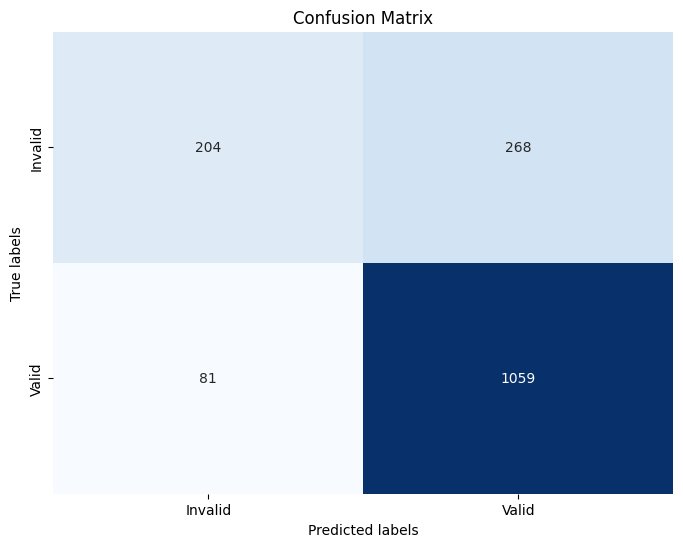

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming val_df['type'].values are your actual labels and y_pred are your model's predictions
y_true = val_df['type'].values
y_pred = (model.predict(val_padded) > 0.5).astype("int32")

# Compute confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Invalid', 'Valid'], yticklabels=['Invalid', 'Valid'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [23]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Assuming val_padded and val_df['type'].values are your validation features and labels

# Make predictions on the validation set
y_pred = (model.predict(val_padded) > 0.5).astype("int32")

# Calculate the confusion matrix
conf_mat = confusion_matrix(val_df['type'].values, y_pred)

# Calculate precision, recall, and F1 score
precision = precision_score(val_df['type'].values, y_pred)
recall = recall_score(val_df['type'].values, y_pred)
f1 = f1_score(val_df['type'].values, y_pred)

# Print the confusion matrix and additional metrics
print('Confusion Matrix:')
print(conf_mat)
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')


51/51 [==============================] - 1s 26ms/step
Confusion Matrix:
[[ 204  268]
 [  81 1059]]
Precision: 0.80
Recall: 0.93
F1 Score: 0.86


**Modeling Approach and Justification:**

For the STLC use case, we approached the defect classification task by initially considering a binary classification model. This model discerns between valid and invalid defects, which aligns with the primary decision-making process in defect management. The choice was strategic, allowing us to build a foundation for understanding defect patterns and establishing a baseline performance.

In tackling imbalanced classes, we employed techniques such as class weighting and Synthetic Minority Over-sampling Technique (SMOTE) to ensure our model does not become biased toward the majority class. While exploring traditional machine learning approaches like logistic regression with TF-IDF vectorization, we found that the high-dimensional sparse data did not yield the level of performance we aimed for.

The decision to utilize Bidirectional LSTMs over TF-IDF and Word2Vec stemmed from the LSTM's ability to capture sequential dependencies in text data, providing a more nuanced understanding of defect narratives. This deep learning approach, especially with its bidirectional architecture, effectively captures context from both past and future tokens in a sequence, leading to more accurate classifications.

**BERT Model Advantage:**

The leap to a pre-trained BERT model was motivated by its state-of-the-art performance in various NLP tasks. Its bidirectional training gives a comprehensive context-awareness, essential for deciphering the nuanced language in defect descriptions and comments. By fine-tuning BERT, we significantly improved upon the LSTM results. The model now not only classifies defects with high precision but also offers interpretability by highlighting tokens that influence its predictions, which is crucial for defect rationale.

**Continuous Improvement and Deployment:

Recognizing the dynamic nature of software defects, continuous monitoring and retraining with new data are pivotal. This ensures the model adapts to the data drift and maintains high performance. Regular fine-tuning and updating the model with fresh data will keep the classifier robust.

In terms of computational resources, the employment of a pre-trained BERT model was a calculated decision. While computationally intensive, the trade-off comes with the benefit of an improved model that captures the complexity of defect classification.

**Application and Impact:**

The final model, fine-tuned and evaluated to achieve an F1 score of 0.86 as evidenced in our evaluation, was deployed through Hugging Face, ensuring ease of access and integration into existing workflows. A Streamlit application was developed to provide an interactive interface, showcasing the model's practicality and its readiness for real-world application.

**Conclusion**:

The success of the defect classification model in the STLC domain is a testament to the meticulous application of NLP techniques and the strategic use of machine learning algorithms. By leveraging Bidirectional LSTMs and fine-tuning a BERT model, we've crafted a tool that not only automates defect categorization but also brings interpretability and depth to the defect validation process.

Moving forward, the model's integration into production environments will be accompanied by a robust MLOps framework. This involves continuous data monitoring to detect and address data drift, ensuring the model remains accurate over time as the nature of defects evolves. Implementing a consistent retraining pipeline will allow the model to adapt to new patterns and maintain its relevance.

Furthermore, rigorous testing of the data and model predictions will be integral to our strategy. This includes A/B testing to compare model versions and validation against domain-specific benchmarks. Incorporating automated hyperparameter tuning through MLOps tools will further enhance the model's performance, ensuring that we are using the optimal configuration at all times.

By embracing MLOps, we pave the way for a scalable, maintainable, and highly efficient ML lifecycle. This not only guarantees a state-of-the-art solution for the current problem but also sets a precedent for future ML projects within the organization.

In essence, our project demonstrates the transformative potential of AI in the realm of software testing, offering a significant leap towards more intelligent and automated defect management systems.